In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd / content/gdrive/MyDrive/cs394n_project/CS394N
! pip3 install -r requirements.txt

In [ ]:
# Update path for custom module support in Google Colab
import sys
sys.path.append('/content/gdrive/MyDrive/cs394n_project/CS394N/src')

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import CIFAR10, FashionMNIST

from tqdm.autonotebook import tqdm, trange

from utils.nets import *
from utils.model_tools import *
from utils.dataset_tools import split_training_data
from utils.feature_extractor import *
from utils.cosine_similarity import *

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
model_dir = './models/'
log_dir = './logs'

model_selection = 'cnn6' # linear | cnn | vgg
dataset_selection = 'cifar10' # cifar10 | fashionmnist

ckpt_file = model_dir+'cnn_cifar10_holdout_[8, 9].pt'

holdout_classes = [8, 9]
new_class = 8

batch_size = 32
num_classes = 9

#### Hyperparameters

In [4]:
num_epochs = 15

initial_learning_rate = 0.001
final_learning_rate = 0.0001

# initial_lr * decay_rate^num_epochs = final_lr
decay_rate = (final_learning_rate/initial_learning_rate)**(1/num_epochs)

loss_fn = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=initial_learning_rate)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

# Data Preparation

In [5]:
if dataset_selection == 'fashionmnist':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)),]) # Images are grayscale -> 1 channel
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
if dataset_selection == 'cifar10':
    train_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_data = CIFAR10(root='./data', train=False, download=True, transform=transform)
elif dataset_selection == 'fashionmnist':
    train_data = FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_data = FashionMNIST(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
total_classes = len(np.unique(train_data.targets))

## FOL

In [14]:
if model_selection == 'linear':
    fol_model = add_output_nodes(ckpt_file, device, arch='linear')
    fol_model.input_layer.requires_grad_(False)
elif model_selection == 'cnn-demo':
    fol_model = add_output_nodes(ckpt_file, device, arch='cnn-demo')
    fol_model.conv1.requires_grad_(False)
    fol_model.conv2.requires_grad_(False)
    fol_model.fc1.requires_grad_(False)
elif model_selection == 'cnn':
    fol_model = add_output_nodes(ckpt_file, device, arch='cnn')
    fol_model.conv_block1.requires_grad_(False)
    fol_model.conv_block2.requires_grad_(False)
    fol_model.conv_block3.Conv5.requires_grad_(False)
    fol_model.conv_block3.Relu5.requires_grad_(False)
    fol_model.conv_block3.BN5.requires_grad_(False)
    
fol_model = fol_model.to(device)

input_size 784
num_outputs 9


In [12]:
fol_optimizer = torch.optim.Adam(fol_model.parameters(), lr=initial_learning_rate)
fol_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=fol_optimizer, gamma=decay_rate)

In [ ]:
# just train on the new class
included_data, excluded_data = split_training_data(train_data, [new_class]) 
train_fol_loader = DataLoader(excluded_data, batch_size=batch_size, shuffle=True, num_workers=2)

# but test on the full 9 classes (old classes + new one, still excluding one)
included_data, excluded_data = split_training_data(test_data, [8])
test_fol_loader = DataLoader(included_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
model_file_fol = weight_dir + model_selection + '_' + dataset_selection + '_' + 'holdout' + '_' + '[8]' + 'fol' + '.pt'

recall_file_fol = log_dir + model_selection + '_' + dataset_selection + '_' + 'holdout' + '_' + '[8]' + 'fol' + '_recall.npy'
train_losses_file_fol = log_dir + model_selection + '_' + dataset_selection + '_' + 'holdout' + '_' + '[8]' + 'fol' + '_train_loss.txt'
test_losses_file_fol = log_dir + model_selection + '_' + dataset_selection + '_' + 'holdout' + '_' + '[8]' + 'fol' + '_test_loss.txt'

### Training Loop

In [8]:
train_losses = []
test_losses = []
#t = trange(num_epochs)
t = range(num_epochs)
y_preds = []
y_actuals = []

for epoch in t:
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train(train_fol_loader, fol_model, loss_fn, fol_optimizer, device)
    test_loss, y_pred, y_actual = test(test_fol_loader, fol_model, loss_fn, device, swap=True, swap_labels=[9,8])
    print('y_pred:', y_pred[:2])
    print('y_actual:', y_actual[:2])
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    y_preds.append(y_pred)
    y_actuals.append(y_actual)
    
    fol_lr_scheduler.step()
    
torch.save(fol_model.state_dict(), model_file_fol)


recalls = get_recall_per_epoch(y_actuals, y_preds, num_classes)
np.save(recall_file_fol, recalls)

with open(train_losses_file_fol, 'w') as fp:
    for s in train_losses:
        fp.write("%s\n" % s)
        
with open(test_losses_file_fol, 'w') as fp:
    for x in test_losses:
        fp.write("%s\n" % x)

print("Done!")

# Ok I'm struggling with getting data loading correct for FOL but I'm not sure we even need it

Epoch 1
-------------------------------


NameError: name 'train_fol_loader' is not defined

## SWIL

In [12]:
def test(dataloader, model, loss_fn, device, swap=False, swap_labels=[], classes = 9) -> float:
    '''
        Model test loop. Performs a single epoch of model updates.

        * USAGE *
        Within a training loop of range(num_epochs) to perform epoch validation, or after training to perform testing.

        * PARAMETERS *
        dataloader: A torch.utils.data.DataLoader object
        model: A torch model which subclasses torch.nn.Module
        loss_fn: A torch loss function, such as torch.nn.CrossEntropyLoss
        optimizer: A torch.optim optimizer
        device: 'cuda' or 'cpu'

        * RETURNS *
        float: The average test loss
    '''

    # TODO: can the swap stuff be removed now?
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    y_pred_list, targets = [], []

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            if swap:
                for i in range(len(y)):
                    if y[i] == swap_labels[0]:
                        y[i] = swap_labels[1]
            X, y = X.to(device), y.to(device)
            pred = model(X)
            targets.append(y.tolist())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            _, y_pred_tags = torch.max(pred, dim=1)
            y_pred_list.append(y_pred_tags.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_pred_list = [item for sublist in y_pred_list for item in sublist]
    
    targets = [item for sublist in targets for item in sublist]

    test_loss /= num_batches
    correct /= size

    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, np.asarray(y_pred_list), np.asarray(targets), 100*correct

In [13]:
if model_selection == 'linear':
    swil_model = add_output_nodes(ckpt_file, arch='linear', device=device)
    swil_model.input_layer.requires_grad_(False)
elif model_selection == 'cnn-demo':
    swil_model = add_output_nodes(ckpt_file, arch='cnn-demo')
    swil_model.conv1.requires_grad_(False)
    swil_model.conv2.requires_grad_(False)
    swil_model.fc1.requires_grad_(False)
elif model_selection == 'cnn6':
    swil_model = add_output_nodes(ckpt_file, device, arch='cnn')
    swil_model.conv_block1.requires_grad_(False)
    swil_model.conv_block2.requires_grad_(False)
    swil_model.conv_block3.Conv5.requires_grad_(False)
    swil_model.conv_block3.Relu5.requires_grad_(False)
    swil_model.conv_block3.BN5.requires_grad_(False)    
    
swil_model = swil_model.to(device)

In [14]:
with open(r'./data/fmnist_sim_scores_boot.txt', 'r') as fp:
    sim_scores = [float(i) for i in fp.readlines()]

sim_sum = sum(sim_scores)
sim_scores

sim_norms = [x/sim_sum for x in sim_scores]

boots_sample_size = 75
sim_sample_sizes = [27 if x < 0.2 else int(x * boots_sample_size*3.52) for x in sim_norms] + [75]
#sim_scores = np.load('./data/fmnist_sim_scores_boot2.npy')
print(sim_sample_sizes)

sim_sample_sizes = np.load('./data/fmnist_sim_scores_boot2.npy')
print(np.array(sim_sample_sizes.tolist(),dtype='uint8'))

[27, 27, 27, 27, 27, 55, 27, 57, 75]
[23 28 21 24 21 20 56 59 73]


In [ ]:
ntrials = 10
#swil_optimizer = torch.optim.Adam(swil_model.parameters(), lr=initial_learning_rate)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=swil_optimizer, gamma=decay_rate)

#fmnist_classes = list(range(8)) + [9]

#with open(r'./data/fmnist_sim_scores_boot.txt', 'r') as fp:
#    sim_scores = [float(i) for i in fp.readlines()]

#sim_sum = sum(sim_scores)
#sim_norms = [x/sim_sum for x in sim_scores]

#boots_sample_size = 75
#sim_sample_sizes = [27 if x < 0.2 else int(x * boots_sample_size*3.52) for x in sim_norms] + [75]

sim_sample_sizes = np.load('./data/cifar10_sim_scores_cat.npy')
sim_sample_sizes = np.array(sim_sample_sizes.tolist(),dtype='uint8')
#sim_sample_sizes = np.zeros(9); sim_sample_sizes[-1] = 5000;
#sim_sample_sizes = np.array(sim_sample_sizes.tolist(),dtype='uint8')
print(sim_scores)

from random import sample
num_epochs = 15
for nt in range(ntrials):
    print(nt)
    """
    if model_selection == 'linear':
        swil_model = add_output_nodes(ckpt_file, arch='linear', device=device)
        swil_model.input_layer.requires_grad_(False)
    elif model_selection == 'cnn-demo':
        swil_model = add_output_nodes(ckpt_file, arch='cnn-demo')
        swil_model.conv1.requires_grad_(False)
        swil_model.conv2.requires_grad_(False)
        swil_model.fc1.requires_grad_(False)
    elif model_selection == 'cnn6':
        swil_model = add_output_nodes(ckpt_file, device, arch='cnn')
        swil_model.conv_block1.requires_grad_(False)
        swil_model.conv_block2.requires_grad_(False)
        swil_model.conv_block3.Conv5.requires_grad_(False)
        swil_model.conv_block3.Relu5.requires_grad_(False)
        swil_model.conv_block3.BN5.requires_grad_(False) 
    """
    swil_model = swil_model.to(device)
    swil_optimizer = torch.optim.Adam(swil_model.parameters(), lr=initial_learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=swil_optimizer, gamma=decay_rate)

    
    # might not need these
    trainloader_gen = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    testloader_gen = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

    fmnist_classes = list(range(8)) + [9]    
    class_subsets, class_idxs, subset_size = generate_dls(train_data, fmnist_classes)
    
    sampled_idxs = []

    for i in range(len(fmnist_classes)):
        idx_sample = sample(class_idxs[i].tolist(), sim_sample_sizes[i])
        sampled_idxs += idx_sample

    swil_train_subset = torch.utils.data.Subset(train_data, sampled_idxs)
    swil_train_dl = torch.utils.data.DataLoader(swil_train_subset, batch_size=1, shuffle=True, num_workers=2)
    included_data, excluded_data = split_training_data(test_data, [8])
    test_swil_loader = DataLoader(included_data, batch_size=batch_size, shuffle=True, num_workers=2)
    
    weight_dir = './logs/'
    model_file = weight_dir + model_selection + '_' + dataset_selection + '_' + 'holdout' + '_' + '[8]' + '_swil' + str(nt) + '.pt'
    recall_file = weight_dir + model_selection + '_' + dataset_selection + '_' + 'holdout' + '_' + '[8]' + '_swil_recall'+ str(nt) + '.npy'
    #train_losses_file = weight_dir + model_selection + '_' + dataset_selection + '_' + 'holdout' + '_' + '[8]' + '_swil_train_loss0.txt'
    test_losses_file = weight_dir + model_selection + '_' + dataset_selection + '_' + 'holdout' + '_' + '[8]' + 'swil_test_loss' + str(nt) + '.txt'
    accuracies_file = weight_dir + model_selection + '_' + dataset_selection + '_' + 'holdout' + '_' + '[8]' + 'swil_accuracies' + str(nt) + '.txt'

    train_losses = []
    test_losses = []
    #t = trange(num_epochs)
    t = range(num_epochs)
    y_preds = []
    y_actuals = []
    accuracies = []

    for epoch in t:
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loss = train(swil_train_dl, swil_model, loss_fn, swil_optimizer, device, swap=True, swap_labels=[9,8])
        test_loss, y_pred, y_actual, acc = test(test_swil_loader, swil_model, loss_fn, device, swap=True, swap_labels=[9,8])
        #train_losses.append(train_loss)
        test_losses.append(test_loss)
        y_preds.append(y_pred)
        y_actuals.append(y_actual)
        accuracies.append(acc)

        #t.set_description(f"Epoch {epoch} train loss: {epoch_loss_train[-1]:.3f}")
        lr_scheduler.step()

    torch.save(swil_model.state_dict(), model_file)

    recalls = get_recall_per_epoch(y_actuals, y_preds, 9)
    np.save(recall_file, recalls)

    #with open(train_losses_file, 'w') as fp:
    #    for s in train_losses:
    #        fp.write("%s\n" % s)

    with open(test_losses_file, 'w') as fp:
        for x in test_losses:
            fp.write("%s\n" % x)

    with open(accuracies_file, 'w') as fp:
        for x in accuracies:
            fp.write("%s\n" % x)

    print("Done!")


[0.17947957193289737, 0.19834868500332298, 0.16892967045388807, 0.18430201993898757, 0.17106040896756045, 0.39231262040835607, 0.16481427150959171, 0.4085420877897833]
0
Epoch 1
-------------------------------
loss: 54.955601  [    0/ 1215]
loss: 11.024211  [ 1000/ 1215]
Test Error: 
 Accuracy: 26.4%, Avg loss: 16.639346 

Epoch 2
-------------------------------
loss: 7.913200  [    0/ 1215]
loss: 0.000000  [ 1000/ 1215]
Test Error: 
 Accuracy: 48.9%, Avg loss: 10.180920 

Epoch 3
-------------------------------
loss: 0.002470  [    0/ 1215]
loss: 2.939363  [ 1000/ 1215]


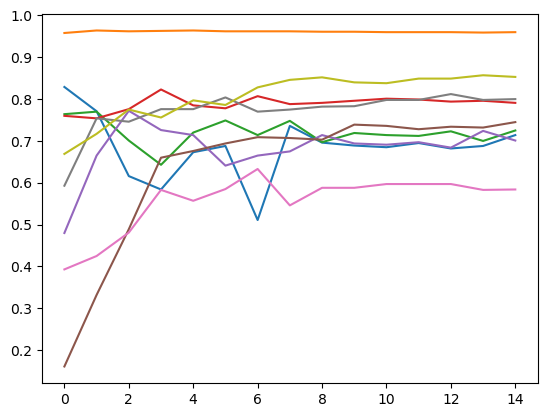

In [51]:
recall0 = np.load('logs/linear_fashionmnist_holdout_[8]_swil_recall0.npy')
recall0

In [ ]:
swil_optimizer = torch.optim.Adam(swil_model.parameters(), lr=initial_learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=swil_optimizer, gamma=decay_rate)

In [24]:
fmnist_classes = list(range(8)) + [9]

# might not need these
FMNIST_trainloader_gen = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
FMNIST_testloader_gen = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

class_subsets, class_idxs, subset_size = generate_dls(train_data, fmnist_classes)

In [25]:
with open(r'./data/fmnist_sim_scores_boot.txt', 'r') as fp:
    sim_scores = [float(i) for i in fp.readlines()]

sim_sum = sum(sim_scores)

sim_norms = [x/sim_sum for x in sim_scores]

boots_sample_size = 75
sim_sample_sizes = [27 if x < 0.2 else int(x * boots_sample_size*3.52) for x in sim_norms] + [75]
print(sim_norms)


[0.09609197807973552, 0.10619435563736243, 0.09044364222319944, 0.09867387953571367, 0.09158442318419929, 0.21004115016932215, 0.08824028937983215, 0.2187302817906353]


In [26]:
from random import sample

sampled_idxs = []

for i in range(len(fmnist_classes)):
    idx_sample = sample(class_idxs[i].tolist(), sim_sample_sizes[i])
    sampled_idxs += idx_sample

swil_train_subset = torch.utils.data.Subset(train_data, sampled_idxs)

swil_train_dl = torch.utils.data.DataLoader(swil_train_subset, batch_size=1, shuffle=True, num_workers=2)

included_data, excluded_data = split_training_data(test_data, [8])
test_swil_loader = DataLoader(included_data, batch_size=batch_size, shuffle=True, num_workers=2)

### Training Loop

In [27]:
weight_dir = './logs/'
model_file = weight_dir + model_selection + '_' + dataset_selection + '_' + 'holdout' + '_' + '[8]' + '_swil0.pt'
recall_file = weight_dir + model_selection + '_' + dataset_selection + '_' + 'holdout' + '_' + '[8]' + '_swil_recall0.npy'
#train_losses_file = weight_dir + model_selection + '_' + dataset_selection + '_' + 'holdout' + '_' + '[8]' + '_swil_train_loss0.txt'
test_losses_file = weight_dir + model_selection + '_' + dataset_selection + '_' + 'holdout' + '_' + '[8]' + 'swil_test_loss0.txt'
accuracies_file = weight_dir + model_selection + '_' + dataset_selection + '_' + 'holdout' + '_' + '[8]' + 'swil_accuracies0.txt'

train_losses = []
test_losses = []
#t = trange(num_epochs)
t = range(num_epochs)
y_preds = []
y_actuals = []
accuracies = []

for epoch in t:
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train(swil_train_dl, swil_model, loss_fn, swil_optimizer, device, swap=True, swap_labels=[9,8])
    test_loss, y_pred, y_actual, acc = test(test_swil_loader, swil_model, loss_fn, device, swap=True, swap_labels=[9,8])
    #train_losses.append(train_loss)
    test_losses.append(test_loss)
    y_preds.append(y_pred)
    y_actuals.append(y_actual)
    accuracies.append(acc)
    
    #t.set_description(f"Epoch {epoch} train loss: {epoch_loss_train[-1]:.3f}")
    lr_scheduler.step()
    
#torch.save(swil_model.state_dict(), model_file)

recalls = get_recall_per_epoch(y_actuals, y_preds, 9)
#np.save(recall_file, recalls)

#with open(train_losses_file, 'w') as fp:
#    for s in train_losses:
#        fp.write("%s\n" % s)
        
#with open(test_losses_file, 'w') as fp:
#    for x in test_losses:
#        fp.write("%s\n" % x)
        
#with open(accuracies_file, 'w') as fp:
#    for x in accuracies:
#        fp.write("%s\n" % x)

print("Done!")

Epoch 1
-------------------------------
loss: 0.005820  [    0/  349]
Test Error: 
 Accuracy: 65.0%, Avg loss: 1.940264 

Epoch 2
-------------------------------
loss: 9.941618  [    0/  349]
Test Error: 
 Accuracy: 71.5%, Avg loss: 0.940611 

Epoch 3
-------------------------------
loss: 4.601825  [    0/  349]
Test Error: 
 Accuracy: 76.2%, Avg loss: 0.732409 

Epoch 4
-------------------------------
loss: 0.062276  [    0/  349]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.688233 

Epoch 5
-------------------------------
loss: 0.000654  [    0/  349]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.673271 

Done!


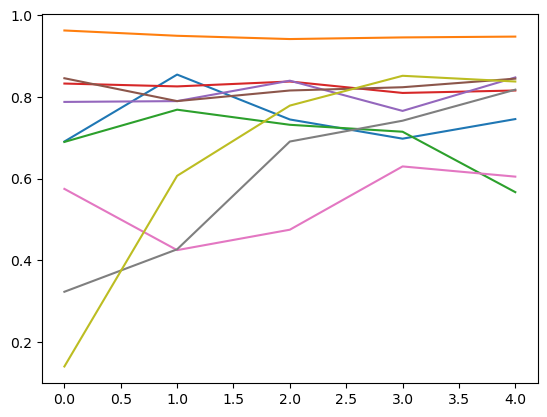

In [29]:
plt.plot(recalls.T)

## G-SWIL

In [ ]:
if model_selection == 'linear':
    gswil_model = add_output_nodes(ckpt_file, arch='linear')
    gswil_model.input_layer.requires_grad_(False)
elif model_selection == 'cnn-demo':
    gswil_model = add_output_nodes(ckpt_file, arch='cnn-demo')
    gswil_model.conv1.requires_grad_(False)
    gswil_model.conv2.requires_grad_(False)
    gswil_model.fc1.requires_grad_(False)
    
gswil_model = gswil_model.to(device)

In [ ]:
optimizer = torch.optim.Adam(gswil_model.parameters(), lr=initial_learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

### Training Loop

In [ ]:
train_losses = []
test_losses = []
#t = trange(num_epochs)
t = range(num_epochs)

for epoch in t:
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train(train_inc_loader, model, loss_fn, optimizer, device)
    test_loss = test(test_inc_loader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    #t.set_description(f"Epoch {epoch} train loss: {epoch_loss_train[-1]:.3f}")
    lr_scheduler.step()
    
torch.save(model.state_dict(), model_file)
print("Done!")